<a href="https://colab.research.google.com/github/Casardo-Chen/wikiart-neural-trasnfer/blob/main/VAE_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data from Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries and utilities

In [ ]:
############################
######## libraries #########
############################
# system
import os
# data science
import numpy as np
import pandas as pd
# visualization
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# pytorch(neural networks)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# vision
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import cv2

In [ ]:
PROJECT = 'Abstract Art VAE'

In [ ]:
# explore some art pictures
mode = 'google drive'
if mode == 'google drive':
  DATA_DIR = './drive/MyDrive/NN/wikiart-neural-transfer-GAN/Abstract_gallery/'
elif mode == 'local':
  DATA_DIR = './data/Abstract_gallery/'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_gallery']
['Abstract_image_2587.jpg', 'Abstract_image_2529.jpg', 'Abstract_image_2556.jpg', 'Abstract_image_2604.jpg', 'Abstract_image_2483.jpg', 'Abstract_image_2507.jpg', 'Abstract_image_2581.jpg', 'Abstract_image_2554.jpg', 'Abstract_image_2520.jpg', 'Abstract_image_2591.jpg']


In [ ]:
###########################
##### set parameters ######
###########################
image_size = (64,64)      # size of each image
batch_size = 100           # how many images are processing at once
latent_size = 100         # the dimensionality of the random noise vector that is used as input to the generator network
epoch_restore = 150       # epoch times

checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

learning_rate = 0.0002
beta1 = 0.5               # the exponential decay rate for the first moment estimate in the Adam optimizer
epochs = 20               # epoch times

# model hyperparameters:
latent_dim = 100
h_dims = [32, 64, 128, 256, 512]
x_dim  = 12288

# load data
dataset = ImageFolder(root=DATA_DIR,
                      transform= T.Compose([T.Resize(image_size),
                                            T.ToTensor(),
                                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])           
                      )
dataloader = DataLoader(dataset=dataset, batch_size=batch_size,shuffle=True,num_workers=2)

# prep device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# split into training set and test set
n = len(dataset)  # total number of examples
n_test = int(0.1 * n)  # take ~10% for test
testset = torch.utils.data.Subset(dataset, range(n_test))  # take first 10%
trainset = torch.utils.data.Subset(dataset, range(n_test, n))  # take the rest   
trainloader = DataLoader(dataset=trainset, batch_size=batch_size,shuffle=True,num_workers=2)
testloader = DataLoader(dataset=testset, batch_size=batch_size,shuffle=True,num_workers=2)

M_N = batch_size/n


In [ ]:
# getting a batch from the dataloader 
batch = next(iter(trainloader))

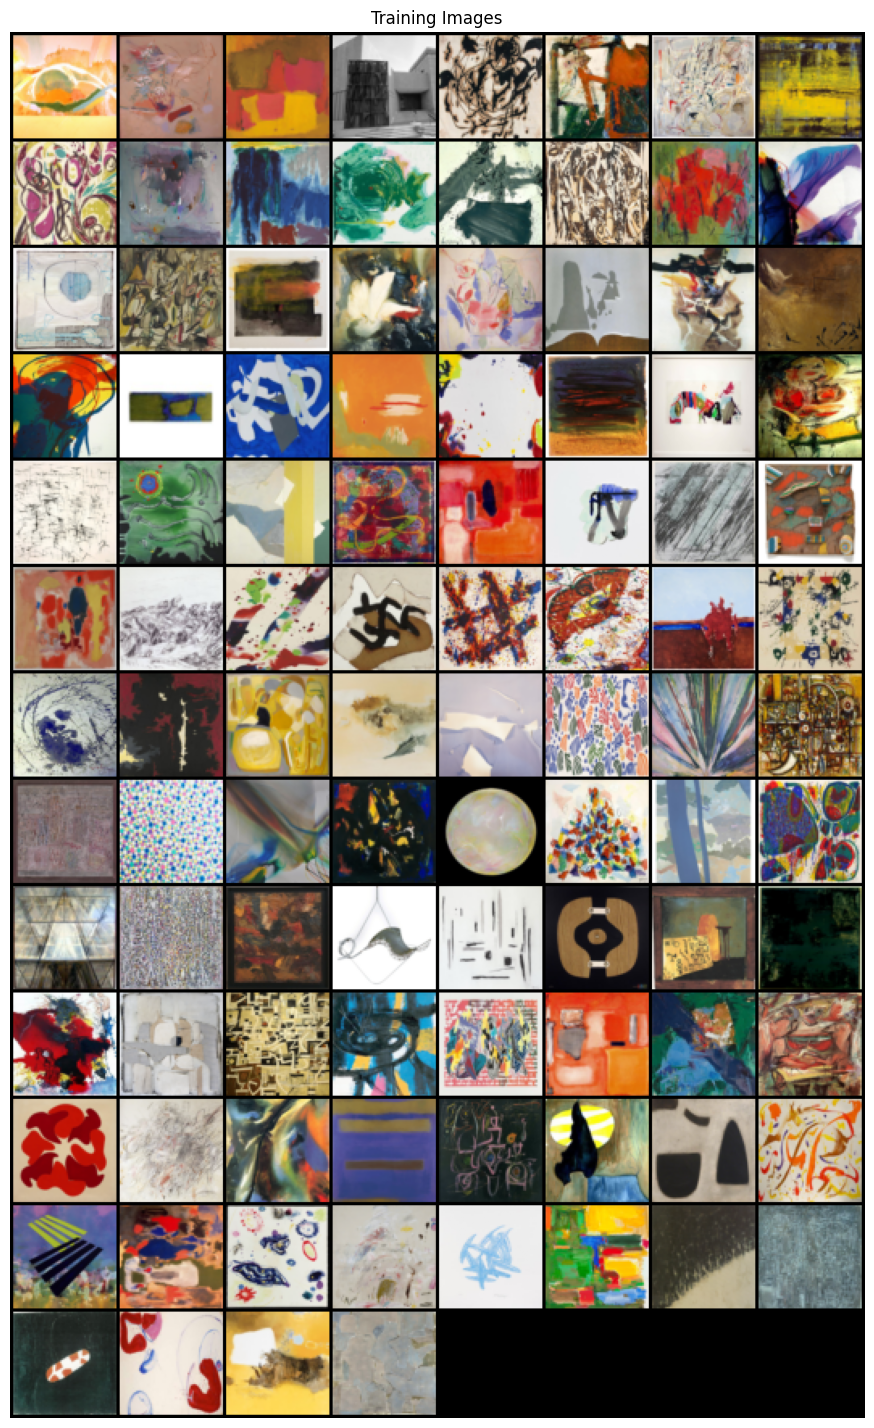

In [ ]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")
# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

## VAE Model

In [ ]:
def init_weights(m):
  class_name = m.__class__.__name__
  if class_name.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif class_name.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
############################
######### Encoder ##########
############################
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Encoder, self).__init__()
        if hidden_dims is None:
            hidden_dims = [32,64, 128, 256, 512]
        modules = []
        in_chan = 3

        # Build Encoder
        '''
        conv1: input 3*64*64; output: 32*32*32 [32=(64-3+2)/2+1]
        conv2: input 32*32*32; output: 64*16*16 [16=(32-3+2)/2+1]
        conv3: input 64*16*16; output: 128*8*8 [8=(16-3+2)/2+1]
        conv4: input 128*8*8; output: 256*4*4 [4=(16-3+2)/2+1]
        conv5: input 256*4*4; output: 512*2*2 [2=(16-3+2)/2+1]
        '''

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels = in_chan, out_channels=h_dim,
                              kernel_size = 3, 
                              stride = 2, 
                              padding = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_chan = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        
    def forward(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        param input: (Tensor) Input tensor to encoder [N x Channel x Height x Width]
        return: (Tensor) List of latent codes
        """
        result = self.encoder(x)
        # print(result.size())
        result = torch.flatten(result, start_dim=1)
        # print(f'flatten:{result.size()}')
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

In [ ]:
############################
######### Decoder ##########
############################
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()
        if hidden_dims is None:
            hidden_dims = [512, 256, 128, 64, 32]
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0] * 4) # hidden_dim * height * width

        # Build Decoder
        '''
        H_out = (H_in−1)×stride−2×padding+(kernel−1)+output_padding+1
        convTranspose1: input 512*2*2; output: 256*4*4 [(2-1)*2-2*1+(3-1)+1+1=4]
        convTranspose2: input 256*4*4; output: 128*8*8 [(4-1)*2-2*1+(3-1)+1+1=8]
        convTranspose3: input 128*8*8; output: 64*16*16 [8-1)*2-2*1+(3-1)+1+1=16]
        convTranspose4: input 64*16*16; output: 32*32*32 [(16-1)*2-2*1+(3-1)+1+1=32]
        final layer:
        convTranspos5: input 32*32*32; output: 32*64*64 [(32-1)*2-2*1+(3-1)+1+1=64]
        conv1: input 32*64*64; output: 3* [(64-3+2)/1+1 = 64]

        '''
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding = 1,
                                      output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels = 3,
                                      kernel_size = 3, padding = 1),
                            nn.Tanh())

        
    def forward(self, z):
        """
        Maps the given latent codes
        onto the image space.
        param z: (Tensor) [B x D]
        return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        # print(f'decoder:{result.size()}')
        result = self.final_layer(result)
        # print(f'final:{result.size()}')
        return result

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder      
        self.Decoder = Decoder      
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z     
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
encoder = Encoder(input_dim=x_dim, hidden_dims=h_dims, latent_dim=latent_dim)
encoder.apply(init_weights)
print(encoder)
print("Trainable Parameters:", count_parameters(encoder))

new_h_dims = h_dims.copy()
new_h_dims.reverse()

decoder = Decoder(latent_dim=latent_dim, hidden_dims = new_h_dims, output_dim = x_dim)
decoder.apply(init_weights)
print(decoder)
print("Trainable Parameters:", count_parameters(decoder))

model = Model(Encoder=encoder, Decoder=decoder).to(device)

Encoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seque

## Loss Function and Optimization

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    recons_loss = F.mse_loss(x_hat, x)
    KLD_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mean ** 2 - log_var.exp(), dim = 1), dim = 0)
    loss = recons_loss + KLD_loss
    return recons_loss , KLD_loss, loss

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Training

In [ ]:
################################
######## Training Loop #########
################################
# list for tracking and training
img_list = []
iters = 0
recon_losses = []
KLD_losses = []
losses = []
print("Start training VAE...")
model.train()

# train the model
for epoch in range(epochs):
    overall_loss = 0
    for i, (x,_) in enumerate(trainloader,0):
      x = x.to(device)
      optimizer.zero_grad()
      # run model
      x_hat, mean, log_var = model(x)
      # print(x_hat.size())
      # loss
      recon_loss, KLD_loss, loss = loss_function(x, x_hat, mean, log_var)  
      overall_loss += loss.item()
      # backpropogation
      loss.backward()
      optimizer.step()
      # tqdm
      if i % 10 == 0:
        tqdm.write('[%d/%d][%d/%d]\tLoss: %.4f' % (epoch, epochs, i, len(trainloader), loss.item()))
      # add to list
      recon_losses.append(recon_loss.item())
      KLD_losses.append(KLD_loss.item())
      losses.append(loss.item())
      if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            noise = torch.randn(100, latent_dim, device=device)
            generated_images = decoder(noise)
        img_list.append(vutils.make_grid(generated_images, padding=2, normalize=True))
      iters += 1    
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (i*batch_size))
    
print("Finish training VAE")

Start training VAE...
[0/20][0/26]	Loss: 0.4755
[0/20][10/26]	Loss: 0.5008
[0/20][20/26]	Loss: 0.4745
	Epoch 1 complete! 	Average Loss:  0.005078673207759857
[1/20][0/26]	Loss: 0.4769
[1/20][10/26]	Loss: 0.5000
[1/20][20/26]	Loss: 0.4285
	Epoch 2 complete! 	Average Loss:  0.00487090003490448
[2/20][0/26]	Loss: 0.4756
[2/20][10/26]	Loss: 0.4635
[2/20][20/26]	Loss: 0.3851
	Epoch 3 complete! 	Average Loss:  0.004845058822631836
[3/20][0/26]	Loss: 0.4206
[3/20][10/26]	Loss: 0.4767
[3/20][20/26]	Loss: 0.4437
	Epoch 4 complete! 	Average Loss:  0.004569900691509247
[4/20][0/26]	Loss: 0.4535
[4/20][10/26]	Loss: 0.4405
[4/20][20/26]	Loss: 0.4176
	Epoch 5 complete! 	Average Loss:  0.004251481544971466
[5/20][0/26]	Loss: 0.4266
[5/20][10/26]	Loss: 0.3931
[5/20][20/26]	Loss: 0.3960
	Epoch 6 complete! 	Average Loss:  0.004049970448017121
[6/20][0/26]	Loss: 0.3441
[6/20][10/26]	Loss: 0.3134
[6/20][20/26]	Loss: 0.3640
	Epoch 7 complete! 	Average Loss:  0.0038072529554367064
[7/20][0/26]	Loss: 0.3598



## Visualization  of the Result

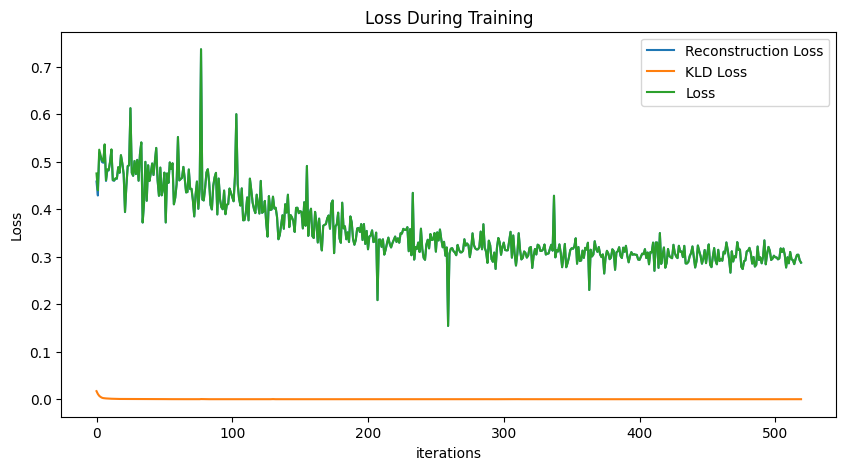

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(recon_losses,label="Reconstruction Loss")
plt.plot(KLD_losses,label="KLD Loss")
plt.plot(losses,label="Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(trainloader)):
        x = x.view(batch_size, 3, 64, 64)
        x = x.to(device)
        
        x_hat, _, _ = model(x)
        break

  0%|          | 0/26 [00:00<?, ?it/s]

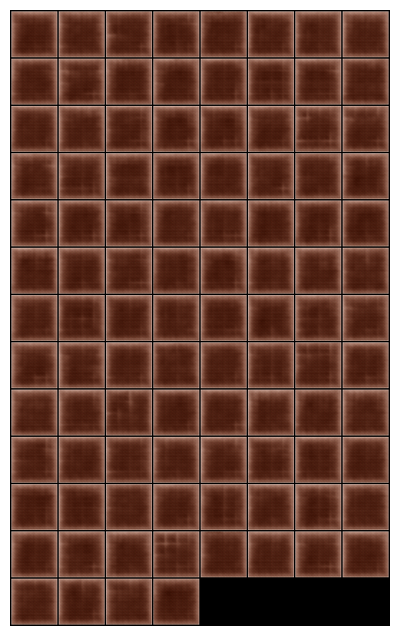

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 3, 64, 64)
    fig = plt.figure()
    plt.imshow(np.transpose(x[idx],(1,2,0)))

tensor([[[ 0.9373,  0.9137,  0.8275,  ...,  0.9137,  0.9137,  0.9137],
         [ 0.9294,  0.7020, -0.0431,  ...,  0.6549,  0.8824,  0.9137],
         [ 0.9216,  0.6549,  0.2941,  ..., -0.1137,  0.7176,  0.9137],
         ...,
         [ 0.6157,  0.2627, -0.0118,  ...,  0.0275,  0.6941,  0.7412],
         [ 0.6627,  0.4902,  0.1451,  ...,  0.4510,  0.7333,  0.7569],
         [ 0.7255,  0.6784,  0.6157,  ...,  0.7412,  0.7569,  0.7725]],

        [[ 0.9294,  0.9216,  0.8039,  ...,  0.9137,  0.9137,  0.9137],
         [ 0.9216,  0.6784, -0.0980,  ...,  0.6235,  0.8745,  0.9137],
         [ 0.9059,  0.6471,  0.2627,  ..., -0.1451,  0.6941,  0.9137],
         ...,
         [ 0.6471,  0.3020,  0.0510,  ...,  0.0275,  0.7176,  0.7882],
         [ 0.7020,  0.5216,  0.1686,  ...,  0.4431,  0.7569,  0.8039],
         [ 0.7647,  0.7255,  0.6784,  ...,  0.7647,  0.7882,  0.8118]],

        [[ 0.9294,  0.9137,  0.8118,  ...,  0.9294,  0.9216,  0.9137],
         [ 0.9137,  0.7020, -0.1137,  ...,  0

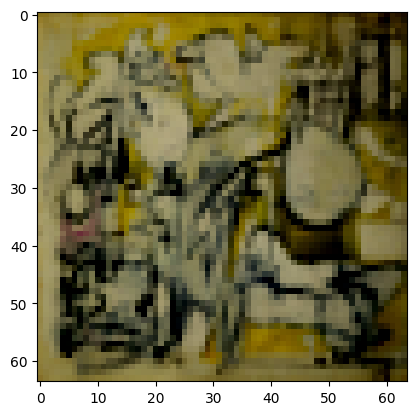

In [ ]:
show_image(x, idx=5)
print(x[20])

tensor([[[0.3679, 0.3147, 0.3019,  ..., 0.3121, 0.3151, 0.3671],
         [0.3174, 0.2460, 0.2369,  ..., 0.2511, 0.2533, 0.3152],
         [0.2972, 0.2384, 0.2440,  ..., 0.2414, 0.2543, 0.3167],
         ...,
         [0.2962, 0.2172, 0.2048,  ..., 0.2104, 0.2176, 0.2904],
         [0.2827, 0.2177, 0.2236,  ..., 0.2078, 0.2273, 0.2973],
         [0.3398, 0.2848, 0.2937,  ..., 0.2790, 0.2997, 0.3533]],

        [[0.3393, 0.2626, 0.2499,  ..., 0.2604, 0.2629, 0.3231],
         [0.2638, 0.1773, 0.1633,  ..., 0.1799, 0.1842, 0.2640],
         [0.2505, 0.1735, 0.1739,  ..., 0.1771, 0.1910, 0.2604],
         ...,
         [0.2364, 0.1451, 0.1294,  ..., 0.1356, 0.1449, 0.2326],
         [0.2351, 0.1541, 0.1533,  ..., 0.1437, 0.1621, 0.2386],
         [0.2994, 0.2312, 0.2344,  ..., 0.2249, 0.2423, 0.3188]],

        [[0.3318, 0.2386, 0.2335,  ..., 0.2374, 0.2442, 0.3087],
         [0.2461, 0.1519, 0.1422,  ..., 0.1543, 0.1618, 0.2454],
         [0.2371, 0.1426, 0.1472,  ..., 0.1502, 0.1635, 0.

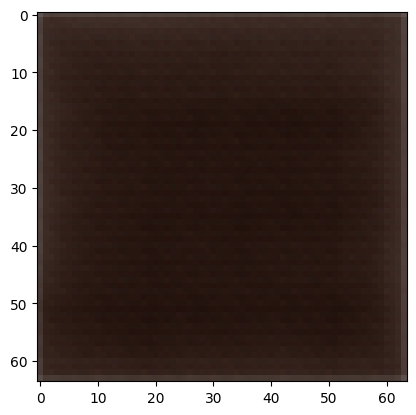

In [ ]:
show_image(x_hat, idx=6)
print(x_hat[6])

In [ ]:
with torch.no_grad():
    noise = torch.randn(100, latent_dim, device=device)
    generated_images = decoder(noise)

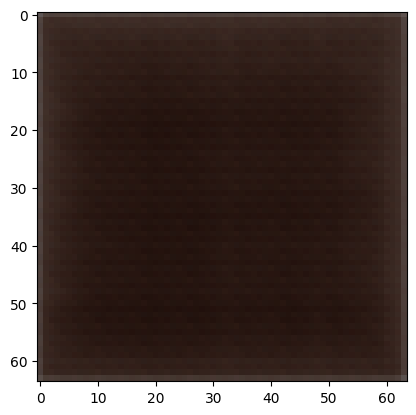

In [ ]:
show_image(generated_images, idx=4)